# Reddit Webscraping
# Introduction
From a relationship advisor point of view, we would want to know if the client is looking for advices or trying to coup from a heartbreaking experience of a past relationship. This project will look into text data to different the 2 different type of text, namely relationship advices and Breakup post from Reddit. 

Subreddit used:
<br>Relationship advice: looking for opinions on how to improve or resolve relationship issue
<br>Breakups: mentioning why the breakup happen, and why it is not resolved

## Problem Statement

Create a classification model to see if a text is about relationship advice or couping from a breakup, and specific keywords for each thread. 

## Executive Summary

The data is webscrapped from 2 reddit subreddit post relationship_advice and BreakUp. A series of transformation, including StopWords removal, Stemming and Vectorization, is done to the raw data to create bag-of-words. A few model is used, mainly LiogisticRegression, Naive Bayes and a few DecisionTrees models to see which model gives us the best accuracy to differentiate the 2 different type of subreddit post. LogisticeRegression was chosen for its higher accuracy and identification of the importance of different features. Lastly, we give our analysis to the results and recommendations to further improve the research and what can be looked into next.
### Content
<br>2. Data Cleaning
<br>3. Preprocessing of text data
<br>4. EDA
<br>5. Model
<br>6. Analysis and Recommendation

# 2. Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from PIL import Image
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

## 2.1 Manual Inspection of data

In [2]:
thread_1 = 'relationship_advice'
thread_2 = 'BreakUps'

df_t1= pd.read_csv('../data/' + (str(thread_1)) + '.csv')
df_t2 = pd.read_csv('../data/' + (str(thread_2)) + '.csv')

In [3]:
df_t1.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday
0,NaN,relationship_advice,**TL;DR on Throwaways:** If you wish to reques...,t2_4det0,False,NaN,0,False,"[meta] It's not required, but if you make a ne...",[],...,/r/relationship_advice/comments/d3okss/meta_it...,all_ads,True,https://www.reddit.com/r/relationship_advice/c...,3883628,1.568378e+09,7,NaN,False,NaN
1,NaN,relationship_advice,We get the stress from social isolation is bad...,t2_4det0,False,NaN,0,False,[meta] One (1) day bans for moral judgment pos...,[],...,/r/relationship_advice/comments/g7ukh7/meta_on...,all_ads,True,https://www.reddit.com/r/relationship_advice/c...,3883628,1.587826e+09,0,NaN,False,NaN
2,NaN,relationship_advice,opps I made a typo in the title sorry! I meant...,t2_7wa6olo9,False,NaN,0,False,My (27/F) cousin (27/F) confessed that she was...,[],...,/r/relationship_advice/comments/iiscjb/my_27f_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598708e+09,0,NaN,False,NaN
3,NaN,relationship_advice,"I (F, 32) have been married to my husband (M,3...",t2_60t4vdow,False,NaN,0,False,My mom is accusing my husband of abusing our d...,[],...,/r/relationship_advice/comments/iiwkf7/my_mom_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598723e+09,0,NaN,False,NaN
4,NaN,relationship_advice,He said the hard r while reading a message tha...,t2_7q6y01ro,False,NaN,0,False,Broke up with my boyfriend because he’s racist,[],...,/r/relationship_advice/comments/ij4pj2/broke_u...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598753e+09,0,NaN,False,NaN


In [4]:
# dropping first and second column as it is the rules as regulations for the thread
df_t1.drop(index = [0, 1], inplace = True)
df_t1.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday
2,NaN,relationship_advice,opps I made a typo in the title sorry! I meant...,t2_7wa6olo9,False,NaN,0,False,My (27/F) cousin (27/F) confessed that she was...,[],...,/r/relationship_advice/comments/iiscjb/my_27f_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598708e+09,0,NaN,False,NaN
3,NaN,relationship_advice,"I (F, 32) have been married to my husband (M,3...",t2_60t4vdow,False,NaN,0,False,My mom is accusing my husband of abusing our d...,[],...,/r/relationship_advice/comments/iiwkf7/my_mom_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598723e+09,0,NaN,False,NaN
4,NaN,relationship_advice,He said the hard r while reading a message tha...,t2_7q6y01ro,False,NaN,0,False,Broke up with my boyfriend because he’s racist,[],...,/r/relationship_advice/comments/ij4pj2/broke_u...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598753e+09,0,NaN,False,NaN
5,NaN,relationship_advice,So where to begin...\nI (27f) am not a touchy ...,t2_76xo5mq0,False,NaN,0,False,Male friend expects/demands I hug him even tho...,[],...,/r/relationship_advice/comments/ij2bxh/male_fr...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598743e+09,0,NaN,False,NaN
6,NaN,relationship_advice,I am currently in a three-year relationship wi...,t2_7uu5n1yd,False,NaN,0,False,My [26m] girlfriend [24f] has opened up to me ...,[],...,/r/relationship_advice/comments/iinhzs/my_26m_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598681e+09,1,NaN,False,NaN


In [5]:
df_t2.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,media_metadata,author_cakeday,poll_data
0,NaN,BreakUps,"Hey, I really miss you. I’m sorry for texting ...",t2_7uvvphr0,False,NaN,0,False,Drunk text! Posting on here instead of actuall...,[],...,False,https://www.reddit.com/r/BreakUps/comments/ij4...,130178,1.598752e+09,0,NaN,False,NaN,NaN,NaN
1,NaN,BreakUps,I no longer have to compromise. I can do exact...,t2_aooid,False,NaN,0,False,Some positives about being single,[],...,False,https://www.reddit.com/r/BreakUps/comments/ij2...,130178,1.598742e+09,1,NaN,False,NaN,NaN,NaN
2,NaN,BreakUps,"Everyday I hear the statement, ""I would do any...",t2_4i38okh,False,NaN,0,False,Why trauma (Breakup) is a good thing,[],...,False,https://www.reddit.com/r/BreakUps/comments/ij5...,130178,1.598754e+09,0,NaN,False,NaN,NaN,NaN
3,NaN,BreakUps,"I can’t touch myself, intimately or otherwise,...",t2_39eluamz,False,NaN,0,False,I can’t take it.,[],...,False,https://www.reddit.com/r/BreakUps/comments/ij3...,130178,1.598747e+09,0,NaN,False,NaN,NaN,NaN
4,NaN,BreakUps,\nDon’t ask them back when they showed you the...,t2_4euwc4gp,False,NaN,0,False,You’re being selfish by holding on to your ex.,[],...,False,https://www.reddit.com/r/BreakUps/comments/ij7...,130178,1.598764e+09,0,NaN,False,NaN,NaN,NaN


### 2.1.1 Check for Duplicates

In [6]:
print(f'No.of duplciated post in Thread {thread_1}: {df_t1.duplicated().sum()}')
print(f'No.of duplciated post in Thread {thread_2}: {df_t2.duplicated().sum()}')

No.of duplciated post in Thread relationship_advice: 0
No.of duplciated post in Thread BreakUps: 0


### 2.1.2 Check number of post

In [7]:
print(f'No. of rows in Thread {thread_1}: {df_t1.shape[0]}')
print(f'No. of rows in Thread {thread_2}: {df_t2.shape[0]}')

No. of rows in Thread relationship_advice: 993
No. of rows in Thread BreakUps: 998


### 2.1.3 Baseline of dataset

In [8]:
df = pd.concat([df_t1,df_t2])[['subreddit', 'selftext', 'created_utc']] # combining both dataframe together, using only relevent columns
print(f'Total No. of rows in DataFrame: {df.shape[0]}')
df.subreddit.value_counts(normalize = True)

Total No. of rows in DataFrame: 1991


BreakUps               0.501256
relationship_advice    0.498744
Name: subreddit, dtype: float64

### 2.1.4 Setting target variable as binary

In [9]:
#setting target variable as binary, 1 for thread 1, 0 for thread 2
df['subreddit'] = df['subreddit'].map({thread_1 : 1, thread_2: 0}) 

#resetting index
df.reset_index(drop=True, inplace = True)
df.subreddit.value_counts(normalize = True)

0    0.501256
1    0.498744
Name: subreddit, dtype: float64

### 2.1.5 Dealing will null values

In [10]:
#checking of null values
df.isna().sum()

subreddit       0
selftext       60
created_utc     0
dtype: int64

In [11]:
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
print(f'Null values left in df: {df.isna().sum().sum()}')
print(f'Number of rows left: {df.shape[0]}')

Null values left in df: 0
Number of rows left: 1931


# 3. EDA
## 3.1 Time of post

In [12]:
df['created_utc'] = pd.to_datetime(df['created_utc'], unit = 's')
df['created_hour'] = [d.hour for d in df['created_utc']]
df['created_minute'] = [d.minute for d in df['created_utc']]
df.head()

,subreddit,selftext,created_utc,created_hour,created_minute
0,1,opps I made a typo in the title sorry! I meant...,2020-08-29 13:26:18,13,26
1,1,"I (F, 32) have been married to my husband (M,3...",2020-08-29 17:36:57,17,36
2,1,He said the hard r while reading a message tha...,2020-08-30 01:56:54,1,56
3,1,So where to begin...\nI (27f) am not a touchy ...,2020-08-29 23:14:43,23,14
4,1,I am currently in a three-year relationship wi...,2020-08-29 06:08:03,6,8


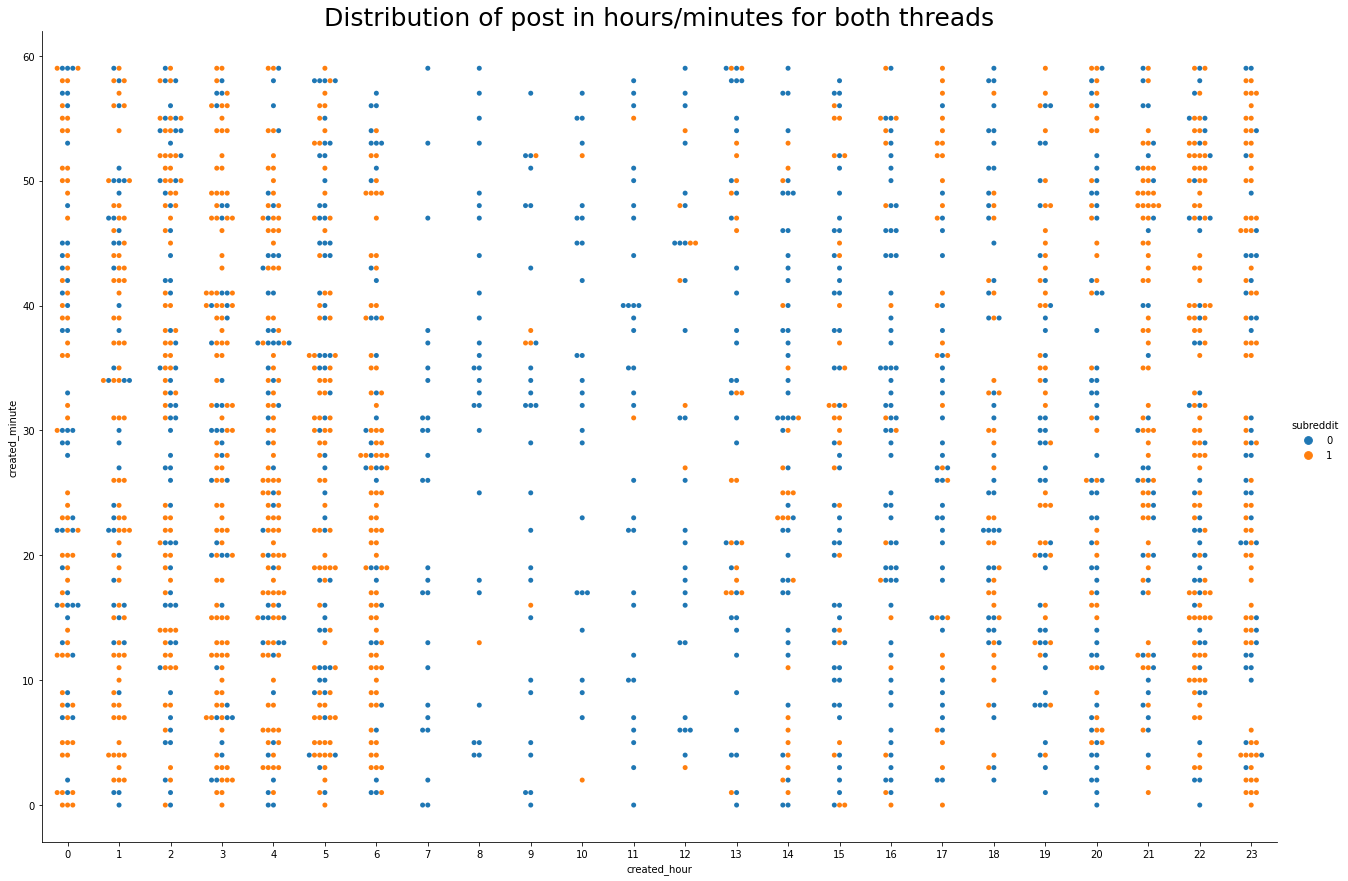

In [13]:
sorted_index = df['created_hour'].unique().sort()
fig = sns.catplot(x = 'created_hour',
                  y = 'created_minute',
                  hue = 'subreddit', #1 = thread_1,0 = thread_2 
                  data = df,
                  kind = 'swarm', 
                  height = 12,
                  aspect = 1.5,
                  order = sorted_index)

plt.title('Distribution of post in hours/minutes for both threads', fontdict = {'fontsize': 25})

ax= fig.axes[0][0]
ax.set_yscale('linear')
plt.show()

### 3.1 Comments
interestingly, most relationship advice post are not posted inbetween 6am - 12pm 

## 3.2 Average length of post in each thread

In [14]:
len_of_t1_post = 0
len_of_t2_post = 0
t1_counter = 0
t2_counter = 0

for i in range(len(df)):
    if df['subreddit'][i] == 1:
        t1_counter += 1
        len_of_t1_post += (len(df['selftext'][i].split())) #spliting the text data to words
    else:
        t2_counter += 1
        len_of_t2_post += (len(df['selftext'][i].split()))
        
print(f'Average number of words in {thread_1} post: {round(len_of_t1_post/t1_counter)}')
print(f'Average number of words in {thread_2} post: {round(len_of_t2_post/t2_counter)}')

Average number of words in relationship_advice post: 367
Average number of words in BreakUps post: 256


### 3.2 comments
post in Breakup threads has about 100 less words on average compared to relationship advices post

# 4. Preprocessing of data
## 4.2 Creating Bag-Of-Words model
### 4.1.1 Train test split data

In [15]:
#Train test split the data
X_train, X_test, y_train, y_test = train_test_split(df['selftext'],
                                                    df['subreddit'],
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df['subreddit'])

In [16]:
print(f'X_train rows: {X_train.shape[0]}, X_test rows: {X_test.shape[0]}')
print(f'y_train rows: {y_train.shape[0]}, y_test rows: {y_test.shape[0]}')

X_train rows: 1544, X_test rows: 387
y_train rows: 1544, y_test rows: 387


In [17]:
X_train.head()

191     So basically, I’ve been dating an amazing pers...
1192    Got dumped very recently and it's been a very ...
266     The weirdest thing is that my ex bf that disre...
1423    We finally broke up after 4 years, we didn’t r...
914     We have been married for just aboit one year n...
Name: selftext, dtype: object

In [18]:
X_train.index[0]

191

In [19]:
X_train[X_train.index[0]] #selecting first index row of train text

'So basically, I’ve been dating an amazing person for around two years now. Let’s call him David. We’ve had issues, but he’s so sweet, kind, perfect, caring and everything I could ask for. Although he’s not exactly the most exciting guy, he feels like home and I’ve been planning on sticking with him for the long term. Although our relationship is amazing, it’s always lacked in... excitement. There hasn’t been much passion, but I’ve heard that’s to be expected when you date someone for a while. I love him all the same, no matter what, though. \n\nI guess that my brain craves passion, however, because this guy that I’ve been friends with for around a year ish has been starting to get to me. Let’s call him Richard. Richard is such a great friend! He’s super funny, cool, and I’m so glad we’ve gotten closer. It’s just that I have a bit of a crush on him and I’ve been developing it more and more over the past week. \n\nIt breaks my heart that I feel like this. I love David so much and having

### 4.1.2 Removing HTML Features

In [20]:
# Removing HTML features if present
example1 = BeautifulSoup(X_train[X_train.index[0]])


print('Before')
print(X_train[X_train.index[0]])
print()
print('AFTER')
print(example1.get_text())

Before
So basically, I’ve been dating an amazing person for around two years now. Let’s call him David. We’ve had issues, but he’s so sweet, kind, perfect, caring and everything I could ask for. Although he’s not exactly the most exciting guy, he feels like home and I’ve been planning on sticking with him for the long term. Although our relationship is amazing, it’s always lacked in... excitement. There hasn’t been much passion, but I’ve heard that’s to be expected when you date someone for a while. I love him all the same, no matter what, though. 

I guess that my brain craves passion, however, because this guy that I’ve been friends with for around a year ish has been starting to get to me. Let’s call him Richard. Richard is such a great friend! He’s super funny, cool, and I’m so glad we’ve gotten closer. It’s just that I have a bit of a crush on him and I’ve been developing it more and more over the past week. 

It breaks my heart that I feel like this. I love David so much and havi

### 4.1.3 Removing numerical values

In [21]:
letters_only = re.sub('[^a-zA-Z]',
                     " ",
                     example1.get_text())

letters_only[:50]

'So basically  I ve been dating an amazing person f'

### 4.1.4 Lowercase text

In [22]:
#lowercase text
lower_case = letters_only.lower()
#splitting text to strings
words = lower_case.split()
words[:10]

['so',
 'basically',
 'i',
 've',
 'been',
 'dating',
 'an',
 'amazing',
 'person',
 'for']

### 4.1.5 Removing stopwords

In [23]:
stop_words = [stopwords.words('english') + ['relationship', 'relation', 'advice', 'breakup', 'break', 'broke']]
words = [w for w in words if w not in stop_words]
words[:10]

['so',
 'basically',
 'i',
 've',
 'been',
 'dating',
 'an',
 'amazing',
 'person',
 'for']

### 4.1.6 Stemming text

In [24]:
p_stemmer = PorterStemmer()
words_pstem = [p_stemmer.stem(i) for i in words]

In [25]:
# Print only those stemmed tokens that are different.
for i in range(len(words)):
    if words[i] != words_pstem[i]:
        print((words[i], words_pstem[i]))

('basically', 'basic')
('dating', 'date')
('amazing', 'amaz')
('years', 'year')
('issues', 'issu')
('caring', 'care')
('everything', 'everyth')
('exactly', 'exactli')
('exciting', 'excit')
('feels', 'feel')
('planning', 'plan')
('sticking', 'stick')
('amazing', 'amaz')
('always', 'alway')
('lacked', 'lack')
('excitement', 'excit')
('expected', 'expect')
('someone', 'someon')
('craves', 'crave')
('however', 'howev')
('because', 'becaus')
('this', 'thi')
('friends', 'friend')
('has', 'ha')
('starting', 'start')
('funny', 'funni')
('developing', 'develop')
('breaks', 'break')
('this', 'thi')
('having', 'have')
('jealousy', 'jealousi')
('issues', 'issu')
('this', 'thi')
('another', 'anoth')
('absolutely', 'absolut')
('knowing', 'know')
('this', 'thi')
('intimate', 'intim')
('flirty', 'flirti')
('wandering', 'wander')
('makes', 'make')
('pursuing', 'pursu')
('anything', 'anyth')
('adamantly', 'adamantli')
('cheating', 'cheat')
('getting', 'get')
('little', 'littl')
('flirtatious', 'flirtati

## 4.2 Creating function for preprocessing of text

In [26]:
stop_words = [stopwords.words('english') + ['relationship', 'relation', 'advice', 'breakup', 
                                            'break', 'broke', 'ex', 'and', 'is', 'or']]
p_stemmer = PorterStemmer()
keywords = ['relationship', 'relation', 'advice', 'breakup', 'break', 'broke', 'ex', 'and', 'is', 'or']

def words_cleaning(text):
    #removing HTML Features
    bs_text = BeautifulSoup(text).get_text()
    
    #Removing numerical values
    letters_only = re.sub('[^a-zA-Z]', " ", bs_text)

    #Lowercasing text
    lower_case = letters_only.lower() 
    
    #splitting text to strings
    words = lower_case.split()
    
    #removing Stopwords
    lowercase_words = [w for w in words if w not in stop_words]
    
    #stemming text
    words_pstem = [p_stemmer.stem(i) for i in lowercase_words]
    
    #subreddit titles keywords removal
    clean_words = [w for w in words_pstem if w not in keywords]
    
    #join words
    join_words = (" ".join(clean_words))
    
    #convert type to object
    return(join_words)

### 4.2.1 Preprocessing of text for model

In [27]:
total_text = len(df.selftext)
print(f'There is a total of {total_text} selftext.')

#instantiate empty list to hold cleaned data
clean_train_text = []
clean_test_text = []

There is a total of 1931 selftext.


In [28]:
print("Cleaning and parsing the training set text...")

# Instantiate counter.
j = 0

# For every review in our training set...
for train_text in X_train:
    
    # Convert text to words, then append to clean_train_text.
    clean_train_text.append(words_cleaning(train_text))
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'selftext {j + 1} of {total_text}.')
    
    j += 1

# Let's do the same for our testing set.
print("Cleaning and parsing the testing set text...")

# For every review in our testing set...
for test_text in X_test:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_test_text.append(words_cleaning(test_text))
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'selftext {j + 1} of {total_text}.')
        
    j += 1
    
print(f'selftext {total_text} of {total_text}.')    
print('Cleaning complete')

Cleaning and parsing the training set text...
selftext 100 of 1931.
selftext 200 of 1931.
selftext 300 of 1931.
selftext 400 of 1931.
selftext 500 of 1931.
selftext 600 of 1931.
selftext 700 of 1931.
selftext 800 of 1931.
selftext 900 of 1931.
selftext 1000 of 1931.
selftext 1100 of 1931.
selftext 1200 of 1931.
selftext 1300 of 1931.
selftext 1400 of 1931.
selftext 1500 of 1931.
Cleaning and parsing the testing set text...
selftext 1600 of 1931.
selftext 1700 of 1931.
selftext 1800 of 1931.
selftext 1900 of 1931.
selftext 1931 of 1931.
Cleaning complete


###  4.2.2 Visualizing processed data

In [29]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

train_data_features = vectorizer.fit_transform(clean_train_text)
test_data_features = vectorizer.transform(clean_test_text)

print(train_data_features.shape)
print(test_data_features.shape)

(1544, 5000)
(387, 5000)


In [30]:
vocab = vectorizer.get_feature_names()
vocab[:10]

['aa',
 'ab',
 'abandon',
 'abil',
 'abit',
 'abiut',
 'abl',
 'abomin',
 'abort',
 'about']

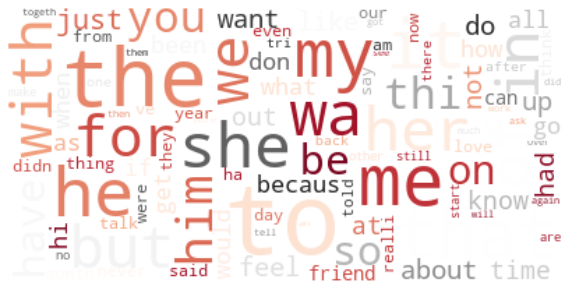

In [31]:
common_words = pd.DataFrame(train_data_features.toarray(), columns = vocab).sum().sort_values(ascending = False)

wordcloud = WordCloud(max_font_size=70,
                      max_words=100,
                      background_color="white",
                      colormap='RdGy')
wordcloud.generate_from_frequencies(frequencies=common_words)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Some of the common words noticed are: Like, now, Time, Want, Friend, Feel

# 5. Model

## 5.1 Baseline model

In [32]:
# Instantiate logistic regression model.
lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000)

# Fit model to training data.
lr.fit(train_data_features, y_train)

# Evaluate model on training data.
print(f'R2 score for Train data set: {lr.score(train_data_features, y_train)}')

# Evaluate model on testing data.
print(f'R2 score for Test data set: {lr.score(test_data_features, y_test)}')

R2 score for Train data set: 0.9980569948186528
R2 score for Test data set: 0.8527131782945736


### 5.1 comments 
the train dataset has a much higher accuracy compared to test data, suggesting a overfitting of features

In [33]:
preds = lr.predict(test_data_features)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


print(f'Specificity: {round(tn / (tn + fp),4)}')
print(f'Sensitivity: {round(tp / (tp + fn),4)}')

Specificity: 0.8617
Sensitivity: 0.8442


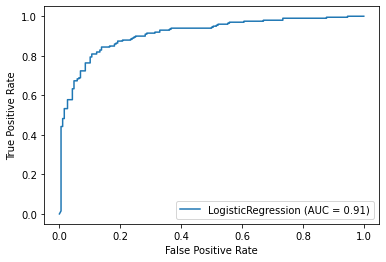

In [34]:
plot_roc_curve(lr, test_data_features, y_test);

## 5.2 Testing with different transformer

### 5.2.1 CountVectorizer Logistic Regression

In [35]:
# Setting pipeline for two stages
cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__min_df': [4, 5, 6],
    'cvec__max_df': [.5 , .6, .7],
    'cvec__ngram_range': [(1,1), (1,2)]
}

gs_cvec_lr = GridSearchCV(cvec_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
t0 = time()
gs_cvec_lr.fit(clean_train_text, y_train)
cvec_test_time = time() - t0
print(f'Best CVEC Parameters: {gs_cvec_lr.best_estimator_[0]}')
print('Fit time:  %0.3fs' % cvec_test_time);

Best CVEC Parameters: CountVectorizer(max_df=0.5, max_features=5000, min_df=4, ngram_range=(1, 2))
Fit time:  187.981s


### 5.2.2 TFIDVectorizer Logistic Regression

In [36]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [3000, 4000, 5000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3, .4],
    'tfid__ngram_range': [(1,1), (1,2)]
}

gs_tfid_lr = GridSearchCV(tfid_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(clean_train_text, y_train)
tfid_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_lr.best_estimator_[0]}')
print('Fit time:  %0.3fs' % tfid_test_time);

Best TFID Parameters: TfidfVectorizer(max_df=0.4, max_features=5000, min_df=3, ngram_range=(1, 2))
Fit time:  151.636s


### 5.2.3 HashingVectorizer Logistic Regression

In [37]:
# Setting pipeline for two stages
hash_lr = Pipeline([
    ('hash', HashingVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'hash__n_features': [1000, 2000, 3000, 4000, 5000],
    'hash__ngram_range': [(1,1), (1,2)]
}

gs_hash_lr = GridSearchCV(hash_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

t0 = time()
gs_hash_lr.fit(clean_train_text, y_train)
hash_test_time = time() - t0
print(f'Best HASH Parameters: {gs_hash_lr.best_estimator_[0]}')
print('Fit time:  %0.3fs' % hash_test_time);

Best HASH Parameters: HashingVectorizer(n_features=5000, ngram_range=(1, 2))
Fit time:  25.003s


### 5.2.4 R2 Scores & ROC AUC Plot (Vectorizer)

In [38]:
print(f'CVEC LogReg Train Score: {gs_cvec_lr.best_score_}')
print(f'CVEC LogReg Test Score: {gs_cvec_lr.score(clean_test_text,y_test)}')
print(f'CVEC Fit Time: {cvec_test_time}')
print('---')
print(f'TFID LogReg Train Score: {gs_tfid_lr.best_score_}')
print(f'TFID LogReg Test Score: {gs_tfid_lr.score(clean_test_text,y_test)}')
print(f'TFID Fit Time: {tfid_test_time}')
print('---')
print(f'HASH LogReg Train Score: {gs_hash_lr.best_score_}')
print(f'HASH LogReg Test Score: {gs_hash_lr.score(clean_test_text,y_test)}')
print(f'HASH Fit Time: {hash_test_time}')

CVEC LogReg Train Score: 0.8134682469633926
CVEC LogReg Test Score: 0.8656330749354005
CVEC Fit Time: 187.9806628227234
---
TFID LogReg Train Score: 0.8542680620350523
TFID LogReg Test Score: 0.875968992248062
TFID Fit Time: 151.63633012771606
---
HASH LogReg Train Score: 0.8050519060227798
HASH LogReg Test Score: 0.834625322997416
HASH Fit Time: 25.00297451019287


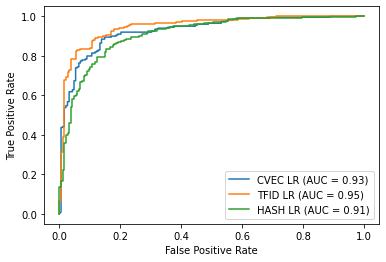

In [39]:
cvec_lr_disp = plot_roc_curve(gs_cvec_lr, clean_test_text, y_test, name = 'CVEC LR')
tfid_lr_disp = plot_roc_curve(gs_tfid_lr, clean_test_text, y_test, name = 'TFID LR', ax = cvec_lr_disp.ax_)
hash_lr_disp = plot_roc_curve(gs_hash_lr, clean_test_text, y_test, name = 'HASH LR', ax = cvec_lr_disp.ax_);

optimally, using TFID seems to return better result, will attempt to loop through different models to see which is better

## 5.3 Testing with different models
### 5.3.1 TFIDVectorizer LogisticRegression (Hyperparameter for model)

In [40]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [4000, 5000],
    'tfid__min_df': [4, 5],
    'tfid__max_df': [.1, .2],
    'tfid__ngram_range': [(1,2)],
    'lr__C': list(np.linspace(1,10,5))
}

gs_tfid_lr = GridSearchCV(tfid_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(clean_train_text, y_train)
tfid_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_test_time);

Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=5000, min_df=4,
                                 ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=1.5, max_iter=5000))])
Fit time:  790.461s


### 5.3.1 TFIDVectorizer KNeighborsClassifier

In [41]:
# Setting pipeline for two stages
tfid_knn = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

pipe_params = {
    'tfid__max_features': [1000, 2000],
    'tfid__min_df': [2, 3],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors': [10,15],
    'knn__p': [1,2]
}

gs_tfid_knn = GridSearchCV(tfid_knn, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

t0 = time()
gs_tfid_knn.fit(clean_train_text, y_train)
knn_test_time = time() - t0
print(f'Best KNN Parameters: {gs_tfid_knn.best_estimator_}')
print('Fit time:  %0.3fs' % knn_test_time);

Best KNN Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=2000, min_df=3,
                                 ngram_range=(1, 2))),
                ('knn', KNeighborsClassifier(n_neighbors=15))])
Fit time:  182.171s


### 5.3.2 TFIDVectorizer MultinomialNB
- MultinomialNB is the best choice here, as the X Variables are all integer counts

In [42]:
# Setting pipeline for two stages
tfid_nb = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tfid__max_features': [900, 1000],
    'tfid__min_df': [2, 3, 4],
    'tfid__max_df': [.3, .4, .5],
    'tfid__ngram_range': [(1,1), (1,2)],
    'nb__alpha': list(np.linspace(0.1,1,5))
}

gs_tfid_nb = GridSearchCV(tfid_nb, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

t0 = time()
gs_tfid_nb.fit(clean_train_text, y_train)
nb_test_time = time() - t0
print(f'Best NB Parameters: {gs_tfid_nb.best_estimator_}')
print('Fit time:  %0.3fs' % nb_test_time);

Best NB Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.5, max_features=1000, min_df=2)),
                ('nb', MultinomialNB(alpha=0.325))])
Fit time:  449.566s


### 5.3.3 TFIDVectorizer DecisionTreeClassifier

In [43]:
# Setting pipeline for two stages
tfid_cart = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('cart', DecisionTreeClassifier())
])

pipe_params = {
    'tfid__max_features': [1000, 2000],
    'tfid__min_df': [2, 3],
    'tfid__max_df': [.3, .4],
    'tfid__ngram_range': [(1,1), (1,2)],
    'cart__min_samples_split': [100 ,200, 300],
    'cart__ccp_alpha': [0, 0.001]
}

gs_tfid_cart = GridSearchCV(tfid_cart, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

t0 = time()
gs_tfid_cart.fit(clean_train_text, y_train)
cart_test_time = time() - t0
print(f'Best CART Parameters: {gs_tfid_cart.best_estimator_}')
print('Fit time:  %0.3fs' % cart_test_time);

Best CART Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=1000, min_df=2)),
                ('cart',
                 DecisionTreeClassifier(ccp_alpha=0, min_samples_split=300))])
Fit time:  300.720s


### 5.3.4 TFIDVectorizer BaggingClassifier

In [44]:
# Setting pipeline for two stages
tfid_bag = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('bag', BaggingClassifier())
])

pipe_params = {
    'tfid__max_features': [2000, 3000],
    'tfid__min_df': [2, 3, 4],
    'tfid__max_df': [.3, .4, .5],
    'tfid__ngram_range': [(1,1), (1,2)]
}

gs_tfid_bag = GridSearchCV(tfid_bag, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
t0 = time()
gs_tfid_bag.fit(clean_train_text, y_train)
bag_test_time = time() - t0
print(f'Best BAG Parameters: {gs_tfid_bag.best_estimator_}')
print('Fit time:  %0.3fs' % bag_test_time);

Best BAG Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.5, max_features=2000, min_df=3,
                                 ngram_range=(1, 2))),
                ('bag', BaggingClassifier())])
Fit time:  362.954s


### 5.3.5 TFIDVectorizer ADABoostClassifier

In [45]:
# Setting pipeline for two stages
tfid_ada = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('ada', AdaBoostClassifier())
])

pipe_params = {
    'tfid__max_features': [2000, 3000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.3, .4],
    'ada__n_estimators': [50,100],
    'ada__learning_rate': [0.9, 1]
}

gs_tfid_ada = GridSearchCV(tfid_ada, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
t0 = time()
gs_tfid_ada.fit(clean_train_text, y_train)
ada_test_time = time() - t0
print(f'Best ADABoost Parameters: {gs_tfid_ada.best_estimator_}')
print('Fit time:  %0.3fs' % ada_test_time);

Best ADABoost Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.4, max_features=3000, min_df=4)),
                ('ada', AdaBoostClassifier(learning_rate=1, n_estimators=100))])
Fit time:  181.747s


### 5.3.5 R2 Scores & ROC AUC Plot (Model)

In [46]:
print(f'TFID LogReg Train Score: {gs_tfid_lr.best_score_}')
print(f'TFID LogReg Test Score: {gs_tfid_lr.score(clean_test_text,y_test)}')
print(f'LogReg Fit Time: {tfid_test_time}')
print('---')
print(f'TFID KNN Train Score: {gs_tfid_knn.best_score_}')
print(f'TFID KNN Test Score: {gs_tfid_knn.score(clean_test_text,y_test)}')
print(f'KNN Fit Time: {knn_test_time}')
print('---')
print(f'TFID NB Train Score: {gs_tfid_nb.best_score_}')
print(f'TFID NB Test Score: {gs_tfid_nb.score(clean_test_text,y_test)}')
print(f'NB Fit Time: {nb_test_time}')
print('---')
print(f'TFID CART Train Score: {gs_tfid_cart.best_score_}')
print(f'TFID CART Test Score: {gs_tfid_cart.score(clean_test_text,y_test)}')
print(f'CART Fit Time: {cart_test_time}')
print('---')
print(f'TFID BAG Train Score: {gs_tfid_bag.best_score_}')
print(f'TFID BAG Test Score: {gs_tfid_bag.score(clean_test_text,y_test)}')
print(f'BAG Fit Time: {bag_test_time}')
print('---')
print(f'TFID ADABoost Train Score: {gs_tfid_ada.best_score_}')
print(f'TFID ADABoost Test Score: {gs_tfid_ada.score(clean_test_text,y_test)}')
print(f'ADABoost Fit Time: {ada_test_time}')

TFID LogReg Train Score: 0.8549174126844029
TFID LogReg Test Score: 0.875968992248062
LogReg Fit Time: 790.4614541530609
---
TFID KNN Train Score: 0.7953263564914049
TFID KNN Test Score: 0.7829457364341085
KNN Fit Time: 182.17053818702698
---
TFID NB Train Score: 0.8354831252889504
TFID NB Test Score: 0.8501291989664083
NB Fit Time: 449.5656986236572
---
TFID CART Train Score: 0.6852078342369603
TFID CART Test Score: 0.7002583979328165
CART Fit Time: 300.72048234939575
---
TFID BAG Train Score: 0.7629449838187702
TFID BAG Test Score: 0.7622739018087855
BAG Fit Time: 362.95358085632324
---
TFID ADABoost Train Score: 0.7778380195855925
TFID ADABoost Test Score: 0.7777777777777778
ADABoost Fit Time: 181.74667596817017


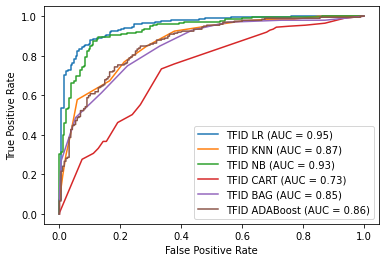

In [47]:
tfid_lr_disp = plot_roc_curve(gs_tfid_lr, clean_test_text, y_test, name = 'TFID LR')
tfid_knn_disp = plot_roc_curve(gs_tfid_knn, clean_test_text, y_test, name = 'TFID KNN', ax = tfid_lr_disp.ax_)
tfid_nb_disp = plot_roc_curve(gs_tfid_nb, clean_test_text, y_test, name = 'TFID NB', ax = tfid_lr_disp.ax_)
tfid_cart_disp = plot_roc_curve(gs_tfid_cart, clean_test_text, y_test, name = 'TFID CART', ax = tfid_lr_disp.ax_)
tfid_bag_disp = plot_roc_curve(gs_tfid_bag, clean_test_text, y_test, name = 'TFID BAG', ax = tfid_lr_disp.ax_)
tfid_ada_disp = plot_roc_curve(gs_tfid_ada, clean_test_text, y_test, name = 'TFID ADABoost', ax = tfid_lr_disp.ax_);

#### 5.3.3 comments:
- TFID LR has the best ROC AUC Score
- Will use LogisticRegression for the final analysis, as it will better tell us the importance of certain keywords from threads

## 5.4 Confusion Matrix

In [48]:
#check best estimator for best performing model
gs_tfid_lr.best_estimator_

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=5000, min_df=4,
                                 ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=1.5, max_iter=5000))])

In [49]:
# Using the best model
predictions = gs_tfid_lr.predict(clean_test_text)

In [50]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print(f'Sensitivity, Accuracy of Thread 1: {round(tp / (tp + fn),4)}')
print(f'Specificity, Accuracy of Thread 2: {round(tn / (tn + fp),4)}')

True Negatives: 159
False Positives: 29
False Negatives: 19
True Positives: 180
Sensitivity, Accuracy of Thread 1: 0.9045
Specificity, Accuracy of Thread 2: 0.8457


- Score of model for both train and test data is very close, suggesting the overfitting issue is resolved
- The model seems to be able to predict Thread 1 better then Thread 2

# 6. Analysis and Recommendation

In [51]:
gs_tfid_lr.best_estimator_

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=5000, min_df=4,
                                 ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=1.5, max_iter=5000))])

In [52]:
thread_1_bag = pd.DataFrame(data = [gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names(),
                     gs_tfid_lr.best_estimator_.named_steps['lr'].coef_[0]]).T.rename(columns = {0 : 'Features', 1: 'Coef'}).sort_values(by = 'Coef', ascending = False).reset_index(drop = True)

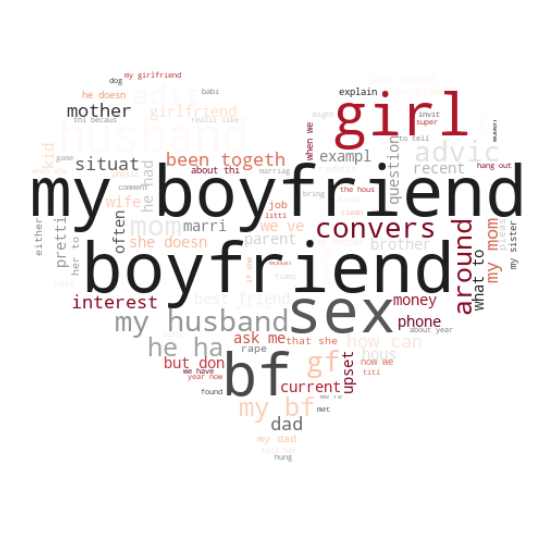

In [53]:
d = {}
for a, x in thread_1_bag.values:
    d[a] = x

mask = np.array(Image.open('../images/heart.jpg'))

wordcloud = WordCloud(max_font_size=70,
                      max_words=100,
                      background_color="white",
                      colormap='RdGy',
                      mask = mask)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [54]:
thread_2_bag = pd.DataFrame(data = [gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names(),
                     gs_tfid_lr.best_estimator_.named_steps['lr'].coef_[0]]).T.rename(columns = {0 : 'Features', 1: 'Coef'}).sort_values(by = 'Coef', ascending = True).reset_index(drop = True)

In [55]:
thread_2_bag['Coef'] = thread_2_bag['Coef']*-1

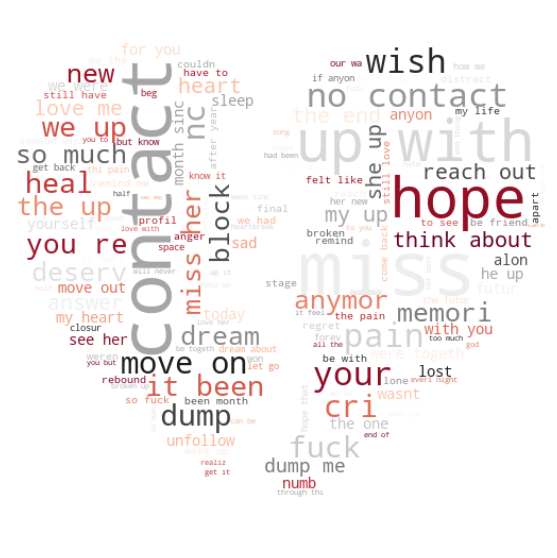

In [56]:
d = {}
for a, x in thread_2_bag.values:
    d[a] = x

mask = np.array(Image.open('../images/heartbreak.jpg'))

wordcloud = WordCloud(max_font_size=70,
                      max_words=150,
                      background_color="white",
                      colormap='RdGy',
                      mask = mask)

wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

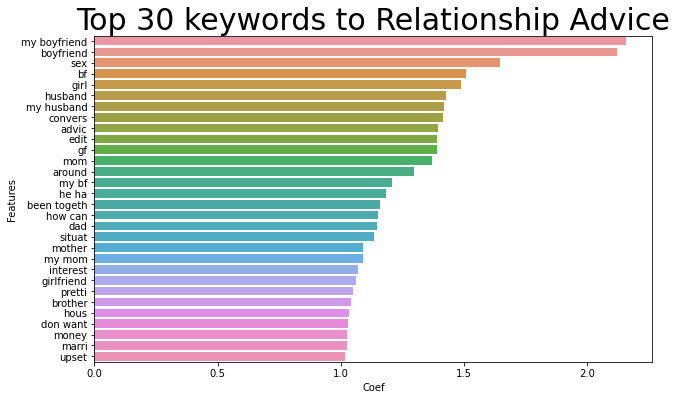

In [57]:
plt.figure(figsize= (10, 6))
plt.title('Top 30 keywords to Relationship Advice',fontdict = {'fontsize': 30})
sns.barplot(x = thread_1_bag['Coef'][:30], y = thread_1_bag['Features'][:30]);

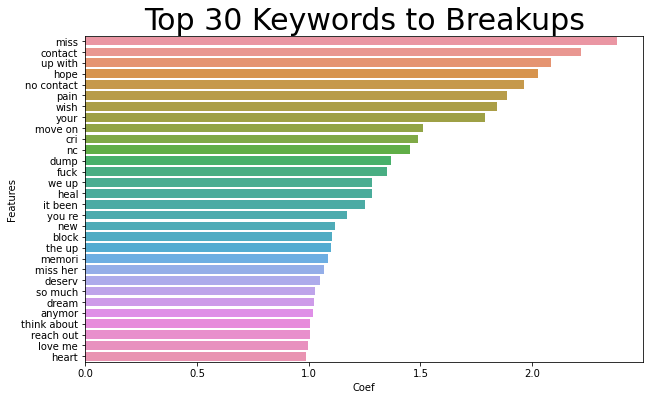

In [58]:
plt.figure(figsize= (10, 6))
plt.title('Top 30 Keywords to Breakups',fontdict = {'fontsize': 30})
sns.barplot(x = thread_2_bag['Coef'][:30], y = thread_2_bag['Features'][:30]);

## 6.1 Checking Misclassified post

In [59]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(gs_tfid_lr.predict(clean_test_text), columns=['predicted'], index = y_test.index)

# Create column for observed values.
results['actual'] = y_test

# Check out first five rows.
results.head()

,predicted,actual
695,0,1
409,1,1
709,1,1
959,1,1
867,1,1


In [60]:
# Find all indices where predicted and true results 
# aren't the same, then save in an array.
row_ids = results[results['predicted']!= results['actual']].index
row_ids

Int64Index([ 695,  260, 1382,  689,  434,  294, 1907, 1607, 1235, 1654,  954,
            1761,  172, 1301, 1635, 1411,  418,  928,  797, 1045, 1428,  831,
             318, 1080, 1149, 1468, 1394, 1868, 1262, 1469, 1207,  258,  605,
            1559, 1825, 1667, 1033,  290, 1084, 1765, 1557,  957,  319, 1640,
            1007,  898, 1731,  828],
           dtype='int64')

### 6.1.1 Misclassified post 1

In [68]:
i = 0
print(f'Post ID: {row_ids[i]}') #695
print('----')
print(X_test[row_ids[i]])
print('----')
print(f'Actual thread: {y_test[row_ids[i]]}')

Post ID: 695
----
I (27F) gave him (27M) every part of me but it was never enough and it would never be enough. I’ve decided to leave him but I want to let go of all the feelings and feel no hurt. I know it’s probably impossible but any tips would help.

I’m completely isolated, we moved across the world and I have no friends or family here. I have to see him everyday until I can get my own place. Feeling lonely doesn’t help either.
----
Actual thread: 1


The content mentioned a breakup, however the author is also looking for advice regarding the relationship. 

### 6.1.2 Misclassified post 2

In [62]:
i = 8
print(f'Post ID: {row_ids[i]}') #1235
print('----')
print(X_test[row_ids[i]])
print('----')
print(f'Actual thread: {y_test[row_ids[i]]}')

Post ID: 1235
----
So let me disclose this my gf of 2 years has had a lot of mental issues because she was sexually abused as a child. I'll start from the beginning, I hadn't been seeing her for over 3 weeks because she said she needed space and one day she randomly showed up to my house. No, calls no texts, she just showed up. She told me that we needed to talk. She started off by saying that she is pressing charges against her abuser and right now it wouldn't be a good time to be in a relationship. And that she didn't want to drag me through all her problems as it wouldn't be fair to me. And she would be moving out of state soon if she couldn't find an apartment. I felt confused, lost, and heartbroken.

It has been a week since this all had occurred. On day 3 of being broken up, I found out she was on tinder, I super liked her and so far she hasn't matched with me. I can't help to be hurt and pissed about this how one can be so immature about things. I haven't bothered to make contac

This post is looking for advice rather then a breakup

### 6.1.3 Misclassified post 3

In [63]:
i = 13
print(f'Post ID: {row_ids[i]}') #1301
print('----')
print(X_test[row_ids[i]])
print('----')
print(f'Actual thread: {y_test[row_ids[i]]}')

Post ID: 1301
----
I’ve been with my partner for over a year now and I love and understand him so deeply and completely but our relationship has not been easy.

His mum hates me. She’s never met me, though. From what he’s told me the root causes of her dismissal of me as a viable partner are essentially racism and classisms (I’m mixed race and poor haha).

Apparently he’s been trying to bring her round to the idea of me for a long time but it ends up in arguments and tension no matter what he says. She emotionally blackmails him and says he will no longer be her son and she will cut him off from family and resources if he chooses me. This is the PG version of stuff I’m guessing as he said he doesn’t feel comfortable divulging most of what she says..

As you can imagine this has completely divided our relationship and we are pretty much on the rocks. He says he feels responsible for his aging mother who raised him all on her own, and as much as he loves me (he has started therapy to cop

This post is looking for relationship advice more then talking about a breakup

# 6.2 Recommendations

The project is classifying post between Relationship Advice and Breakup threads to differentiate the 2 categories.

The findings shown that Relatiosnhip_advice tend to mention more about the other person(Boyfriend,spouse,wife,gf,bf) as opposed to Breakup when it is more self focused(dream, memory,sad, better, move on). 

The model has an accuracy of 89% for Relationship advice predictions and 83% for breakup post.

There is a small misclassification of the model, and after taking a manual check on the post, it can be interpreted that the post would have been better classified under the opposite thread instead. 

Its interesting to note that around the 6am - 12pm time period, not much relationship advices are posted. This interpretation would be better look into by a psychology specialist to see if there is a relationship in time of post with the content.

There is some limitation to the data, as we are scraping through reddit posts, there is a chance of misclassification as mentioned before, where the public post a different content in the wrong thread. what can be done is to restrict the posting with moderators and ensure the content is align with the thread before it is posted, to ensure the content is correct to the thread mentioned.

